# Planar transient heat problem
[![Google Collab Book](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/meyer-nils/torch-fem/blob/main/examples/basic/planar/thermal_transient.ipynb)

Compute the transient temperature distribution in a planar problem.

In [1]:
import torch

import matplotlib.pyplot as plt
from torchfem.examples import get_example_file
from torchfem.io import import_mesh
from torchfem.materials import IsotropicConductivity2D
from torchfem.planar import PlanarHeat

from matplotlib import animation
from torchfem.plot_utils import embed_animation_gif

# Set default data type to double precision
torch.set_default_dtype(torch.float64)

# Dimensions (thickness of plate t and edge length L)
t = 0.01
L = 0.2

## Transient heat equation on planar domain

In [2]:
# material properties
kappa = 500.0
rho = 7850.0
cp = 500.0

In [3]:
# Material model
material = IsotropicConductivity2D(kappa=kappa, cp=cp, rho=rho)

# Import mesh
mesh = import_mesh(get_example_file("plate_hole.vtk"), material)

# origin in center
mesh.nodes[:, :2] -= 0.5 * L

# get radius
distance_to_center = torch.linalg.norm(mesh.nodes, dim=-1)
R = distance_to_center.min()

plate = PlanarHeat(mesh.nodes, mesh.elements, material)
plate.thickness[:] = t

# Fixed temperature at left end
left = plate.nodes[:, 0] < -0.5 * L + 1e-6
plate.constraints[left] = True
plate.displacements[left, 0] = 5.0

# Fixed temperature at right end
right = plate.nodes[:, 0] > 0.5 * L - 1e-6
plate.constraints[right] = True
plate.displacements[right, 0] = 20.0

# Fixed temperature at radius
radius = torch.isclose(distance_to_center, R)
plate.constraints[radius] = True
plate.displacements[radius, 0] = 0.0


# solver settings
end_time = 40.0
delta_t = 0.1

times = torch.tensor([0.0, end_time])

# Solve
temp, rfl, hf, temp_grad, _ = plate.time_integration(
    times, delta_t, verbose=False, return_intermediate=True
)



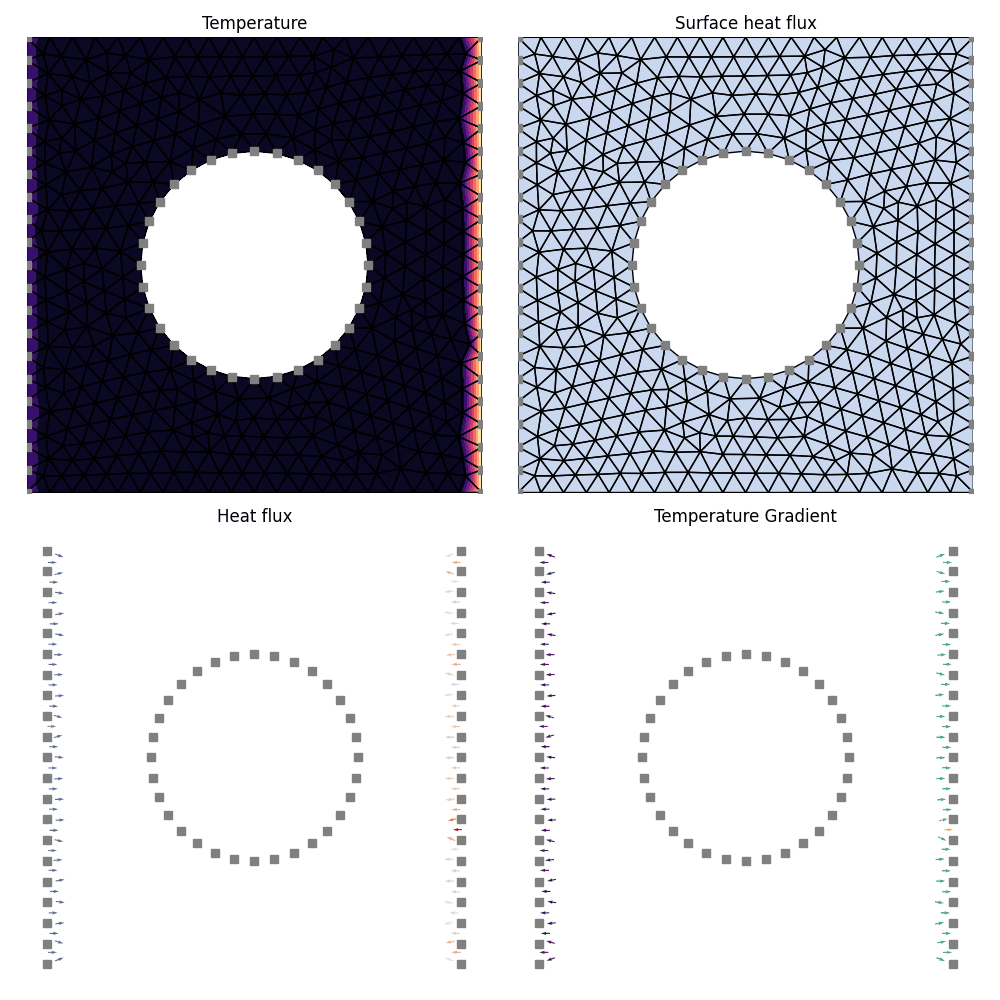

<Figure size 640x480 with 0 Axes>

In [4]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))


def plot_state(i):
    plate.plot(
        node_property=temp[i].ravel(),
        cmap="magma",
        title="Temperature",
        ax=ax1,
        vmin=0.0,
        vmax=20.0,
    )
    plate.plot(
        node_property=rfl[i].ravel(),
        cmap="coolwarm",
        title="Surface heat flux",
        ax=ax2,
        vmin=rfl.min(),
        vmax=rfl.max(),
    )
    plate.plot(
        element_vector_field=-hf[i],  # negative sign
        cmap="coolwarm",
        title="Heat flux",
        color="gray",
        linewidth=0.0,
        normalized_vector_field=True,
        ax=ax3,
        vmin=hf.min(),
        vmax=hf.max(),
    )
    plate.plot(
        element_vector_field=temp_grad[i],
        title="Temperature Gradient",
        ax=ax4,
        cmap="viridis",
        color="gray",
        linewidth=0.0,
        normalized_vector_field=True,
        vmin=temp_grad.min(),
        vmax=temp_grad.max(),
    )

    if i == 0:
        plt.tight_layout()


def animate(i):
    # Note. this is pretty slow and should be optimized.
    # updating the data on the tricontour is not intended in mpl.
    ax1.clear()
    ax2.clear()
    ax3.clear()
    ax4.clear()

    plot_state(i)

    return ()  # we have to return a (empty) tuple of artists


anim = animation.FuncAnimation(
    fig,
    animate,
    init_func=plot_state(0),
    frames=range(len(temp))[::10],
    interval=20,
    blit=False,
    repeat=False,
)

plt.close(fig)  # prevent static plot
embed_animation_gif(anim, fps=10)  # <- This embeds the GIF directly
